### **Note:** This notebook is designed to run on **Google Colab**. Please use the provided Colab link to open the notebook. Also, Please make sure to check the **documentation link** just below for detailed instructions on how to execute the notebook. Thank you!!!

##                           NAME - ATHISH RAJ MOHAN


### GITHUB USERNAME - ATHISHRAJMOHAN-DSCI552-SU2025
### USC ID - 7556541447

### Google Colab link of my Project Notebook- https://colab.research.google.com/drive/1ufBX7ovxWNCSYxMLJIwx5SzSIOfxcS0-?usp=sharing

## Instructions for Running the Project - https://docs.google.com/document/d/1RdCMhfUInrzaYZ7ga8s3LZppwxE4_06YvgjaY4WNk3M/edit?usp=sharing

##### The below line unzip's the upload compressed data folder.


In [ ]:
import os
import zipfile

if not os.path.exists('data'):
    with zipfile.ZipFile('data.zip', 'r') as zip_ref:
        zip_ref.extractall()
    print('Successfully Un-Zipped the folder!!')
else:
    print('The folder has already been unzipped! ')

Successfully Un-Zipped the folder!!


In [ ]:
# Installing the requirements from the requirements.txt file
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.6 MB/s eta 0:00:00


 ## 1. Transfer Learning for Image Classification
 ### (a) In this problem, we are trying to build a classifier that distinguishes images of nine types of waste.

##### Information of connection to GPU

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul 29 02:15:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

##### Import Statements

In [ ]:
import os
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, f1_score, roc_auc_score, precision_score, recall_score

from tensorflow.keras import layers, models, regularizers, Sequential, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


### (b) Data Exploration and Pre-processing



##### Listing the folder names

In [ ]:
base_path = '/content/data/RealWaste'
print(os.listdir(base_path))

['7-Plastic', '6-Paper', '3-Glass', '2-Food Organics', '1-Cardboard', '8-Textile Trash', '5-Miscellaneous Trash', '4-Metal', '9-Vegetation']


##### Listing number of image per folder and total number of images we are working with

In [ ]:
category_folders = []

for item in os.listdir(base_path):
  item_path = os.path.join(base_path, item)
  if os.path.isdir(item_path):
    category_folders.append(item)

img_exts = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')

image_counts = {}
total_images = 0

for folder in category_folders:
  folder_path = os.path.join(base_path, folder)
  count = 0
  for file in os.listdir(folder_path):
    if file.lower().endswith(img_exts):
      count += 1
  image_counts[folder] = count
  total_images += count

# Display counts for each category
for category, count in image_counts.items():
    print(f"{category}: {count} images")
print(f"\nTotal images: {total_images}")

7-Plastic: 921 images
6-Paper: 500 images
3-Glass: 420 images
2-Food Organics: 411 images
1-Cardboard: 461 images
8-Textile Trash: 318 images
5-Miscellaneous Trash: 495 images
4-Metal: 790 images
9-Vegetation: 436 images

Total images: 4752


  #### i. Images are numbered in each folder. Select the first 80% of the images in each folder as your training set and the rest as the test set. You can encode your classes using one-hot encoding.

In [ ]:
# Extracting class name
def extract_label(folder):
    match = re.search(r'-\s*(.*)', folder)
    return match.group(1).strip() if match else folder


train_files, test_files = [], []
train_labels, test_labels = [], []

img_exts = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
categories = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])

for cat in categories:
  label = extract_label(cat)
  folder = os.path.join(base_path, cat)
  images = sorted([img for img in os.listdir(folder) if img.lower().endswith(img_exts)])
  n = len(images)
  train_count = int(0.8*n) # 80% of images in each folder as training set

  train_imgs = images[:train_count]
  test_imgs = images[train_count:]

  for img in train_imgs:
    train_files.append(os.path.join(folder, img))
    train_labels.append(label)

  for img in test_imgs:
    test_files.append(os.path.join(folder, img))
    test_labels.append(label)

print('----------Splitting the data into Training set and Test set is completed successfully-------------')

----------Splitting the data into Training set and Test set is completed successfully-------------


#### Performing One Hot Encoding - Train set and Test set

In [ ]:
all_labels = sorted(list(set(train_labels + test_labels)))
encoder = LabelBinarizer()
encoder.fit(all_labels)

#transforming all the labels
y_train = encoder.transform(train_labels)
y_test = encoder.transform(test_labels)

label_to_int = {label: idx for idx, label in enumerate(all_labels)}
train_label_indices = [label_to_int[l] for l in train_labels]
test_label_indices = [label_to_int[l] for l in test_labels]

y_train = to_categorical(train_label_indices, num_classes=len(all_labels))
y_test = to_categorical(test_label_indices, num_classes=len(all_labels))


##### Displaying one example from each category, selected according to the one-hot encoded label assignments - Training Set

In [ ]:
seen = set()
print(" One-hot examples by category:\n")

for label, vector in zip(train_labels, y_train):
    if label not in seen:
        print(f"{label:12s} → {vector}")
        seen.add(label)
    if len(seen) == len(all_labels):
        break

 One-hot examples by category:

Cardboard    → [1. 0. 0. 0. 0. 0. 0. 0. 0.]
Food Organics → [0. 1. 0. 0. 0. 0. 0. 0. 0.]
Glass        → [0. 0. 1. 0. 0. 0. 0. 0. 0.]
Metal        → [0. 0. 0. 1. 0. 0. 0. 0. 0.]
Miscellaneous Trash → [0. 0. 0. 0. 1. 0. 0. 0. 0.]
Paper        → [0. 0. 0. 0. 0. 1. 0. 0. 0.]
Plastic      → [0. 0. 0. 0. 0. 0. 1. 0. 0.]
Textile Trash → [0. 0. 0. 0. 0. 0. 0. 1. 0.]
Vegetation   → [0. 0. 0. 0. 0. 0. 0. 0. 1.]


##### Displaying one example from each category, selected according to the one-hot encoded label assignments - Test Set

In [ ]:
seen = set()
for label, vector in zip(test_labels, y_test):
    if label not in seen:
        print(f"{label:12s} → {vector}")
        seen.add(label)
    if len(seen) == len(all_labels):
        break

Cardboard    → [1. 0. 0. 0. 0. 0. 0. 0. 0.]
Food Organics → [0. 1. 0. 0. 0. 0. 0. 0. 0.]
Glass        → [0. 0. 1. 0. 0. 0. 0. 0. 0.]
Metal        → [0. 0. 0. 1. 0. 0. 0. 0. 0.]
Miscellaneous Trash → [0. 0. 0. 0. 1. 0. 0. 0. 0.]
Paper        → [0. 0. 0. 0. 0. 1. 0. 0. 0.]
Plastic      → [0. 0. 0. 0. 0. 0. 1. 0. 0.]
Textile Trash → [0. 0. 0. 0. 0. 0. 0. 1. 0.]
Vegetation   → [0. 0. 0. 0. 0. 0. 0. 0. 1.]


 ### ii. In case all the images do not have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [ ]:
## helper function for pre-processing the image
def resize_with_padding(img, target_size=(224, 224)):
  h, w = img.shape[:2] #original dimension
  scale = min(target_size[0]/w, target_size[1]/h) #calculating sale so that the largest dimension matches target_Size
  new_w, new_h = int(w*scale), int(h*scale)
  resized_img = cv2.resize(img, (new_w, new_h)) # resize image using calculated dimensions

  # calculate the padding for width and height to reach exact target_size
  pad_w = target_size[0] - new_w
  pad_h = target_size[1] - new_h
  top = pad_h // 2               # padding on top
  bottom = pad_h - top           # padding on bottom
  left = pad_w // 2              # padding on left
  right = pad_w - left           # padding on right

# Adding zero (black) padding equally on all sides
  padded_img = cv2.copyMakeBorder(
      resized_img, top, bottom, left, right,
      borderType=cv2.BORDER_CONSTANT,
      value=[0, 0, 0]  # Black padding; can change to other color if needed
  )
  return padded_img


In [ ]:
def preprocess_images(image_paths, target_size=(224, 224)):
    images = []
    for path in image_paths:
        img = cv2.imread(path)                      # Load image from disk
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB color space
        img = resize_with_padding(img, target_size) # Resize with padding
        images.append(img)                          # Add processed image to list
    # Stack all processed images into a NumPy array for model input
    return np.array(images, dtype=np.uint8)

# Preprocess train and test images
X_train = preprocess_images(train_files, target_size=(224, 224))
X_test = preprocess_images(test_files, target_size=(224, 224))

In [ ]:
# Show the shape of processed datasets (num_samples, height, width, channels)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (3798, 224, 224, 3)
X_test shape: (954, 224, 224, 3)


 ### (c) Transfer Learning
 #### i. When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. In this project, you will use pre-trained models ResNet50, ResNet100, EfficientNetB0, and VGG16. For those pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

 #### ii. To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

In [ ]:
data_augmentation = Sequential([
    layers.RandomCrop(224, 224), # Cropping image to 224*224 pixels
    layers.RandomZoom(0.2), # Zooming the image in or out by up to 20%
    layers.RandomRotation(0.2), # Rotating the image by up to ±20% of a full turn
    layers.RandomFlip('horizontal'), # Flipping images horizontally
    layers.RandomContrast(0.2), # adjust the contrast by up to ±20%
    layers.RandomTranslation(0.2, 0.2) # Translate the images width/height by up to ±20%
])

#### iii. Use ReLU activation functions in the last layer and a softmax layer, along with L2 regularization, batch normalization, and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

#####  ResNet50

In [ ]:
num_classes = len(all_labels)  # number of classes in my dataset

inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Real-time image augmentation

# Load pre-trained ResNet50 without the classification head
resnet50_base = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
resnet50_base.trainable = False  # Freeze all pre-trained layers

x = resnet50_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(
    128, activation='relu', kernel_regularizer=regularizers.l2(0.01)
)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_resnet50 = models.Model(inputs, outputs)

model_resnet50.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_resnet50.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,851,657 (90.99 MB)

 Trainable params: 263,689 (1.01 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

#####  ResNet100

In [ ]:
num_classes = len(all_labels)  # number of classes in my dataset

inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Real-time image augmentation

# Load pre-trained ResNet101 without classification head
resnet101_base = ResNet101(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
resnet101_base.trainable = False  # Freeze all pre-trained layers

x = resnet101_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(
    128, activation='relu', kernel_regularizer=regularizers.l2(0.01)
)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_resnet101 = models.Model(inputs, outputs)

model_resnet101.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_resnet101.summary()


171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet101 (Functional)          │ (None, 7, 7, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,922,121 (163.73 MB)

 Trainable params: 263,689 (1.01 MB)

 Non-trainable params: 42,658,432 (162.73 MB)

#####  EfficientNetB0

In [ ]:
num_classes = len(all_labels)  # Set the number of output classes for your task

# Define model input shape (images of size 224x224, with 3 color channels)
inputs = Input(shape=(224, 224, 3))

# Data augmentation pipeline (should be defined elsewhere), applies only during training
x = data_augmentation(inputs)

# Load EfficientNetB0 with ImageNet weights, exclude original top classification layer
EfficientNetB0_base = EfficientNetB0(
    include_top=False,          # Remove the original classifier
    weights='imagenet',         # Load pre-trained ImageNet weights
    input_shape=(224, 224, 3)
)
EfficientNetB0_base.trainable = False    # Freeze all layers in the pre-trained model

# Pass augmented input through the base model (no training on base model's weights)
x = EfficientNetB0_base(x, training=False)

# Reduce feature maps to a single vector using global average pooling
x = layers.GlobalAveragePooling2D()(x)

# Add a fully connected layer with ReLU activation and L2 regularization
x = layers.Dense(
    128,
    activation='relu',
    kernel_regularizer=regularizers.l2(0.01)
)(x)

# Apply batch normalization for faster and more stable training
x = layers.BatchNormalization()(x)

# Apply dropout (randomly disables 20% of neurons) to reduce overfitting
x = layers.Dropout(0.2)(x)

# Output layer: Dense layer with softmax activation for multi-class classification
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Create the full Keras model from inputs to outputs
model_EfficientNetB0 = models.Model(inputs, outputs)

# Compile the model with Adam optimizer, categorical cross-entropy loss, and accuracy metric
model_EfficientNetB0.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary to check the architecture
model_EfficientNetB0.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,215,212 (16.08 MB)

 Trainable params: 165,385 (646.04 KB)

 Non-trainable params: 4,049,827 (15.45 MB)

In [ ]:
num_classes = len(all_labels)  # number of classes in my dataset

inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Real-time image augmentation

# Load pre-trained VGG16 without classification head
vgg16_base = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
vgg16_base.trainable = False  # Freeze all pre-trained layers

x = vgg16_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(
    128, activation='relu', kernel_regularizer=regularizers.l2(0.01)
)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_vgg16 = models.Model(inputs, outputs)

model_vgg16.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_vgg16.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,782,025 (56.39 MB)

 Trainable params: 67,081 (262.04 KB)

 Non-trainable params: 14,714,944 (56.13 MB)

 ### iv. Train the networks for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Use a randomly selected subset of 20% of each class as the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

#### Now, further split train_files into train/val (stratified) - Forming Validation Set

In [ ]:

val_files, val_labels = [], []
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

print("Train images:", len(train_files))
print("Validation images:", len(val_files))
print("Test images:", len(test_files))



Train images: 3038
Validation images: 760
Test images: 954


#### Performing One Hot Encoding - Validation set

In [ ]:
val_label_indices   = [label_to_int[label] for label in val_labels]
y_val   = to_categorical(val_label_indices, num_classes=num_classes)
X_val = preprocess_images(val_files, target_size=(224, 224))

##### Displaying one example from each category, selected according to the one-hot encoded label assignments - Validation Set

In [ ]:
seen = set()
for label, vector in zip(val_labels, y_val):
    if label not in seen:
        print(f"{label:12s} → {vector}")
        seen.add(label)
    if len(seen) == len(all_labels):
        break

Metal        → [0. 0. 0. 1. 0. 0. 0. 0. 0.]
Cardboard    → [1. 0. 0. 0. 0. 0. 0. 0. 0.]
Vegetation   → [0. 0. 0. 0. 0. 0. 0. 0. 1.]
Miscellaneous Trash → [0. 0. 0. 0. 1. 0. 0. 0. 0.]
Paper        → [0. 0. 0. 0. 0. 1. 0. 0. 0.]
Plastic      → [0. 0. 0. 0. 0. 0. 1. 0. 0.]
Food Organics → [0. 1. 0. 0. 0. 0. 0. 0. 0.]
Textile Trash → [0. 0. 0. 0. 0. 0. 0. 1. 0.]
Glass        → [0. 0. 1. 0. 0. 0. 0. 0. 0.]



One-hot encoded = y_train, y_val, y_test

### Training of ResNet50

Epoch 1/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.4892 - loss: 3.2099 - val_accuracy: 0.6013 - val_loss: 2.0620 - learning_rate: 0.0010
Epoch 2/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 33s 36ms/step - accuracy: 0.6652 - loss: 1.7215 - val_accuracy: 0.7395 - val_loss: 1.3215 - learning_rate: 0.0010
Epoch 3/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 0.6757 - loss: 1.5192 - val_accuracy: 0.6855 - val_loss: 1.4181 - learning_rate: 0.0010
Epoch 4/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - accuracy: 0.6692 - loss: 1.4161 - val_accuracy: 0.7579 - val_loss: 1.1435 - learning_rate: 0.0010
Epoch 5/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.6757 - loss: 1.3945 - val_accuracy: 0.6961 - val_loss: 1.3089 - learning_rate: 0.0010
Epoch 6/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.6768 - loss: 1.3737 - val_accuracy: 0.7079 - val_loss: 1.2159 - learning_rate: 0.0010
Epoch 7/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.6

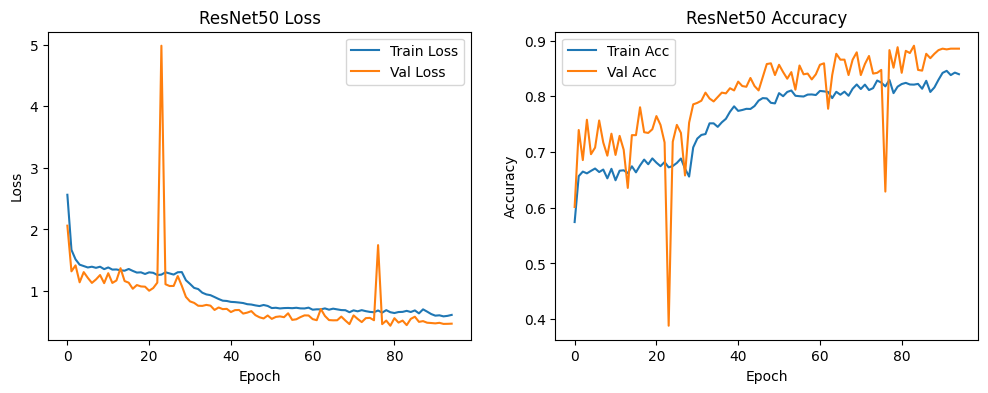

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # Early Stopping
ckpt = ModelCheckpoint('best_resnet50.keras', save_best_only=True, monitor='val_loss') # Saving the best model

#Adaptive Learning Rate using ReduceLROnPlateau technique
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=1e-6, verbose = 1)

# Training
history = model_resnet50.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=5, # Using 5 samples per grdient update
    epochs=100,
    callbacks=[early_stop, ckpt, reduce_lr],
    verbose=1 # printing training progress and callback messages on the screen
)

model_resnet50.save('final_resnet50.keras') ## Saving the last model as well as it cotains best weights

# Plotting
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('ResNet50 Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('ResNet50 Accuracy')
plt.show()


### Training of ResNet101

Epoch 1/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 49s 64ms/step - accuracy: 0.7220 - loss: 1.0568 - val_accuracy: 0.7671 - val_loss: 0.9640 - learning_rate: 1.0000e-04
Epoch 2/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 79s 60ms/step - accuracy: 0.7240 - loss: 1.0706 - val_accuracy: 0.8461 - val_loss: 0.6721 - learning_rate: 1.0000e-04
Epoch 3/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 85s 64ms/step - accuracy: 0.7626 - loss: 0.9235 - val_accuracy: 0.8329 - val_loss: 0.6708 - learning_rate: 1.0000e-04
Epoch 4/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.7541 - loss: 0.9411 - val_accuracy: 0.8461 - val_loss: 0.6213 - learning_rate: 1.0000e-04
Epoch 5/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 76s 57ms/step - accuracy: 0.7707 - loss: 0.9047 - val_accuracy: 0.8447 - val_loss: 0.6325 - learning_rate: 1.0000e-04
Epoch 6/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 44s 58ms/step - accuracy: 0.7644 - loss: 0.8977 - val_accuracy: 0.8513 - val_loss: 0.5951 - learning_rate: 1.0000e-04
Epoch 7/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 86s 6

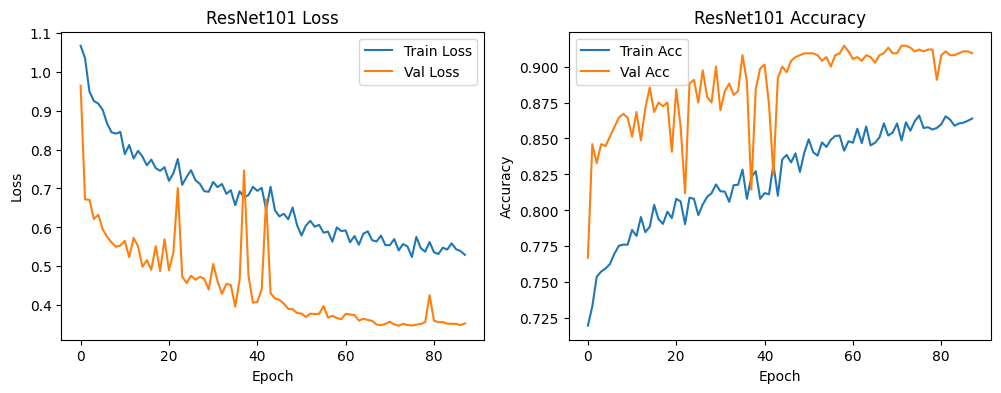

In [ ]:
fearly_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
ckpt = ModelCheckpoint('best_resnet101.keras', save_best_only=True, monitor='val_loss')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=1e-6, verbose = 1)

history = model_resnet101.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=5, epochs=100,
    callbacks=[early_stop, ckpt, reduce_lr], verbose=1
)

model_resnet101.save('final_resnet101.keras')

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('ResNet101 Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('ResNet101 Accuracy')
plt.show()


### Training of EfficientNetB0

Epoch 1/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 35s 31ms/step - accuracy: 0.5079 - loss: 3.5503 - val_accuracy: 0.7842 - val_loss: 1.8926 - learning_rate: 0.0010
Epoch 2/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.7003 - loss: 2.0128 - val_accuracy: 0.7961 - val_loss: 1.4285 - learning_rate: 0.0010
Epoch 3/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.7011 - loss: 1.6504 - val_accuracy: 0.8105 - val_loss: 1.2840 - learning_rate: 0.0010
Epoch 4/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.6931 - loss: 1.5634 - val_accuracy: 0.8303 - val_loss: 1.1277 - learning_rate: 0.0010
Epoch 5/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.7074 - loss: 1.4604 - val_accuracy: 0.8316 - val_loss: 1.1001 - learning_rate: 0.0010
Epoch 6/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.7116 - loss: 1.4145 - val_accuracy: 0.7934 - val_loss: 1.1524 - learning_rate: 0.0010
Epoch 7/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.7

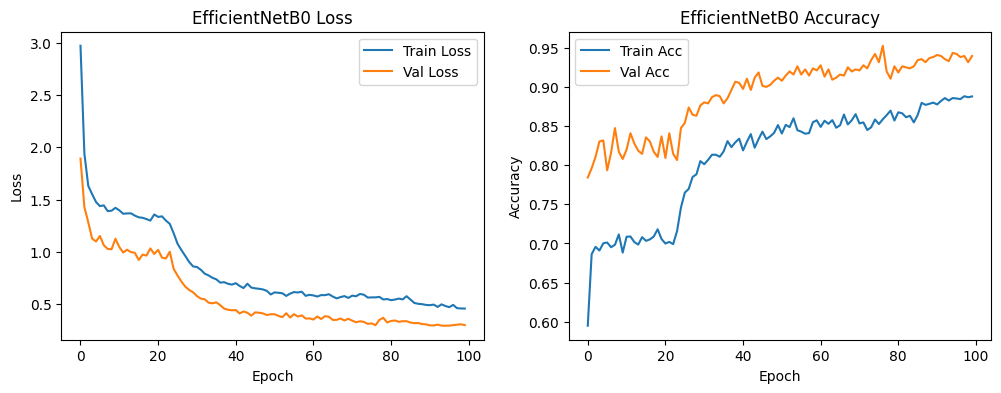

In [ ]:

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
ckpt = ModelCheckpoint('best_efficientnetb0.keras', save_best_only=True, monitor='val_loss')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=1e-6, verbose = 1)

history = model_EfficientNetB0.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=5, epochs=100,
    callbacks=[early_stop, ckpt, reduce_lr], verbose=1
)

model_EfficientNetB0.save('final_efficientnetb0.keras')

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('EfficientNetB0 Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('EfficientNetB0 Accuracy')
plt.show()


### Training of Model Vgg16

Epoch 1/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4147 - loss: 3.2750 - val_accuracy: 0.7079 - val_loss: 1.8162 - learning_rate: 0.0010
Epoch 2/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 39s 43ms/step - accuracy: 0.6244 - loss: 1.9110 - val_accuracy: 0.7487 - val_loss: 1.3688 - learning_rate: 0.0010
Epoch 3/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.6188 - loss: 1.6372 - val_accuracy: 0.7632 - val_loss: 1.1394 - learning_rate: 0.0010
Epoch 4/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.6408 - loss: 1.4797 - val_accuracy: 0.7645 - val_loss: 1.0717 - learning_rate: 0.0010
Epoch 5/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.6442 - loss: 1.4106 - val_accuracy: 0.7724 - val_loss: 0.9924 - learning_rate: 0.0010
Epoch 6/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.6408 - loss: 1.3790 - val_accuracy: 0.7526 - val_loss: 1.1345 - learning_rate: 0.0010
Epoch 7/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.6

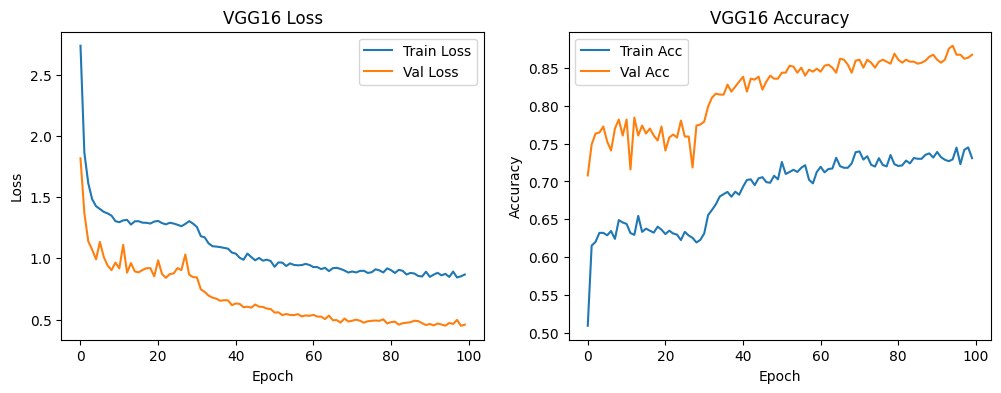

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
ckpt = ModelCheckpoint('best_vgg16.keras', save_best_only=True, monitor='val_loss')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=1e-6, verbose = 1)

history = model_vgg16.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=5, epochs=100,
    callbacks=[early_stop, ckpt, reduce_lr], verbose=1
)

model_vgg16.save('final_vgg16.keras')

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('VGG16 Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('VGG16 Accuracy')
plt.show()


 #### v. Report training, validation, and test Precision, Recall, AUC, and F1 score for those models. Is there a model that clearly outperforms others? Remember that this is a multi-class classification problem.

In [ ]:
def report_full_metrics(model, X, y, class_names, name):
    """
    Outputs per-class and overall metrics (macro, micro, weighted, samples avg) (if present) for multi-class classification.
    """
    y_pred = model.predict(X)
    y_true = y.argmax(axis=1)
    y_pred_class = y_pred.argmax(axis=1)

    # Per-class scores
    cls_report = classification_report(
        y_true, y_pred_class, target_names=class_names, zero_division=0, output_dict=True
    )

    print(f"\n{name} — Per-class Precision, Recall, F1:")
    print("{:<20} {:<10} {:<10} {:<10}".format("Class", "Precision", "Recall", "F1"))
    for label in class_names:
        prec = cls_report[label]['precision']
        rec  = cls_report[label]['recall']
        f1   = cls_report[label]['f1-score']
        print(f"{label:<20} {prec:<10.3f} {rec:<10.3f} {f1:<10.3f}")

    # Averaged scores: macro, micro, weighted, samples (if present)
    metrics = ['precision', 'recall', 'f1-score']
    avgs = ['macro avg', 'micro avg', 'weighted avg', 'samples avg']

    print("\n---- Averaged scores ----")
    for avg in avgs:
        if avg in cls_report:
            vals = [cls_report[avg][m] for m in metrics]
            print(f"{avg.title():<15} Precision: {vals[0]:.3f}, Recall: {vals[1]:.3f}, F1: {vals[2]:.3f}")

    # Macro-averaged AUC (one-vs-rest for multi-class)
    try:
        macro_auc = float(roc_auc_score(y, y_pred, average='macro', multi_class='ovr'))
    except Exception:
        macro_auc = float('nan')
    print(f"\nMacro-Averaged AUC: {macro_auc:.3f}\n")
    return (
        cls_report['macro avg']['precision'],
        cls_report['macro avg']['recall'],
        cls_report['macro avg']['f1-score'],
        macro_auc
    )


#### Reporting metrics for ResNet50

In [ ]:
class_names = all_labels

# ResNet50 example
report_full_metrics(model_resnet50, X_train, y_train, class_names, "ResNet50 Train")
report_full_metrics(model_resnet50, X_val, y_val, class_names, "ResNet50 Validation")
report_full_metrics(model_resnet50, X_test, y_test, class_names, "ResNet50 Test")

# Repeat similarly for ResNet101, EfficientNetB0, VGG16


119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step

ResNet50 Train — Per-class Precision, Recall, F1:
Class                Precision  Recall     F1        
Cardboard            0.779      0.959      0.860     
Food Organics        0.959      0.854      0.903     
Glass                0.950      0.851      0.898     
Metal                0.885      0.856      0.870     
Miscellaneous Trash  0.809      0.783      0.796     
Paper                0.906      0.915      0.910     
Plastic              0.900      0.834      0.866     
Textile Trash        0.921      0.913      0.917     
Vegetation           0.821      0.991      0.898     

---- Averaged scores ----
Macro Avg       Precision: 0.881, Recall: 0.884, F1: 0.880
Weighted Avg    Precision: 0.881, Recall: 0.876, F1: 0.876

Macro-Averaged AUC: 0.992

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step

ResNet50 Validation — Per-class Precision, Recall, F1:
Class                Precision  Recall     F1        
Cardboard            0.800      0.973    

(0.761773959389505, 0.743095844882641, 0.7440900314412159, 0.9661247843861062)

#### Reporting metrics for ResNet101

In [ ]:
resnet101_train = report_full_metrics(model_resnet101, X_train, y_train, class_names, "ResNet101 Train")
resnet101_val   = report_full_metrics(model_resnet101, X_val, y_val, class_names, "ResNet101 Validation")
resnet101_test  = report_full_metrics(model_resnet101, X_test, y_test, class_names, "ResNet101 Test")

119/119 ━━━━━━━━━━━━━━━━━━━━ 32s 239ms/step

ResNet101 Train — Per-class Precision, Recall, F1:
Class                Precision  Recall     F1        
Cardboard            0.814      0.976      0.888     
Food Organics        0.944      0.930      0.937     
Glass                0.943      0.938      0.940     
Metal                0.875      0.943      0.908     
Miscellaneous Trash  0.933      0.848      0.889     
Paper                0.902      0.940      0.920     
Plastic              0.959      0.800      0.873     
Textile Trash        0.958      0.906      0.931     
Vegetation           0.894      0.997      0.943     

---- Averaged scores ----
Macro Avg       Precision: 0.914, Recall: 0.920, F1: 0.914
Weighted Avg    Precision: 0.914, Recall: 0.909, F1: 0.909

Macro-Averaged AUC: 0.996

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step

ResNet101 Validation — Per-class Precision, Recall, F1:
Class                Precision  Recall     F1        
Cardboard            0.798      0.959  

#### Reporting metrics for EfficientNetB0

In [ ]:
efficientnetb0_train = report_full_metrics(model_EfficientNetB0, X_train, y_train, class_names, "EfficientNetB0 Train")
efficientnetb0_val   = report_full_metrics(model_EfficientNetB0, X_val, y_val, class_names, "EfficientNetB0 Validation")
efficientnetb0_test  = report_full_metrics(model_EfficientNetB0, X_test, y_test,  class_names, "EfficientNetB0 Test")

119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step

EfficientNetB0 Train — Per-class Precision, Recall, F1:
Class                Precision  Recall     F1        
Cardboard            0.854      0.986      0.916     
Food Organics        0.982      0.988      0.985     
Glass                0.944      0.955      0.950     
Metal                0.955      0.934      0.944     
Miscellaneous Trash  0.951      0.884      0.916     
Paper                0.983      0.890      0.934     
Plastic              0.945      0.932      0.938     
Textile Trash        0.923      0.988      0.954     
Vegetation           0.975      1.000      0.987     

---- Averaged scores ----
Macro Avg       Precision: 0.946, Recall: 0.951, F1: 0.947
Weighted Avg    Precision: 0.947, Recall: 0.945, F1: 0.945

Macro-Averaged AUC: 0.998

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step

EfficientNetB0 Validation — Per-class Precision, Recall, F1:
Class                Precision  Recall     F1        
Cardboard            0.849     

#### Reporting metrics for VGG16

In [ ]:
# For VGG16
vgg16_train = report_full_metrics(model_vgg16, X_train, y_train, class_names, "VGG16 Train")
vgg16_val   = report_full_metrics(model_vgg16, X_val, y_val, class_names, "VGG16 Validation")
vgg16_test  = report_full_metrics(model_vgg16, X_test, y_test, class_names, "VGG16 Test")


119/119 ━━━━━━━━━━━━━━━━━━━━ 24s 179ms/step

VGG16 Train — Per-class Precision, Recall, F1:
Class                Precision  Recall     F1        
Cardboard            0.762      0.905      0.827     
Food Organics        0.908      0.899      0.904     
Glass                0.920      0.854      0.886     
Metal                0.828      0.859      0.843     
Miscellaneous Trash  0.841      0.626      0.718     
Paper                0.812      0.875      0.842     
Plastic              0.850      0.819      0.835     
Textile Trash        0.917      0.823      0.867     
Vegetation           0.844      0.983      0.908     

---- Averaged scores ----
Macro Avg       Precision: 0.854, Recall: 0.849, F1: 0.848
Weighted Avg    Precision: 0.848, Recall: 0.845, F1: 0.843

Macro-Averaged AUC: 0.987

24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step

VGG16 Validation — Per-class Precision, Recall, F1:
Class                Precision  Recall     F1        
Cardboard            0.812      0.932      0.86

## Model Performance Summary and Conclusion

We evaluated four deep learning models-**ResNet50, ResNet101, EfficientNetB0, and VGG16**-for multi-class waste classification, benchmarking accuracy using macro-averaged **Precision, Recall, F1 score, and AUC** on the training, validation, and test sets.

### **Test Set Macro-Averaged Metrics**

| Model           | Precision | Recall | F1 Score | AUC   |
|-----------------|-----------|--------|----------|-------|
| ResNet50        | 0.762     | 0.743  | 0.744    | 0.966 |
| ResNet101       | 0.788     | 0.774  | 0.772    | 0.972 |
| EfficientNetB0  | **0.825** | **0.820** | **0.820** | **0.978** |
| VGG16           | 0.728     | 0.713  | 0.709    | 0.958 |

### **Key Observations**

- **EfficientNetB0** achieved the highest scores across all test set metrics—**macro F1 (0.820)**, **precision (0.825)**, **recall (0.820)**, and **AUC (0.978)**—indicating the strongest and most balanced performance across all classes.
- **ResNet101** followed, maintaining strong generalization with macro F1 of 0.772 and AUC of 0.972.
- **ResNet50** performed respectably but trailed ResNet101 and EfficientNetB0, especially on challenging classes (e.g., “Miscellaneous Trash”).
- **VGG16** consistently lagged behind, particularly on less-represented or difficult classes, with the lowest macro F1 (0.709) and AUC (0.958). This suggests limited capacity or overfitting compared to deeper or more optimized models.

### **Conclusion**

> **EfficientNetB0 clearly outperforms all other models on this multi-class classification problem.**  
> It achieves the best test set precision, recall, F1-score, and AUC, and demonstrates robust performance on both common and difficult classes, making it the most reliable choice for deployment or further research for this waste classification task.


---


### Challenge & How I Overcame it

- Initially, my models struggled with poor performance, achieving only 20–30% accuracy despite using the default Adam optimizer. After digging deeper into optimization strategies and learning rate dynamics, I discovered and implemented ReduceLROnPlateau, a Keras callback that monitors a chosen metric (e.g. validation loss) and automatically reduces the learning rate when performance stagnates. This helped the model escape local minima and adapt to plateaus during training.

- I also revisited my early stopping configuration. Originally, I had set a high patience value of 40 epochs, which delayed termination even after the model stopped improving. Upon reevaluation, I reduced the patience to 15 epochs, enabling the training process to halt earlier—saving compute and preventing overfitting.

- This iterative tuning of hyperparameters was a pivotal learning moment. It reinforced the importance of adaptive training strategies and helped me move beyond default settings to achieve more efficient and accurate models



### References
#### 1) https://keras.io/
#### 2) https://builtin.com/data-science/transfer-learning
#### 3) https://en.wikipedia.org/wiki/Batch_normalization
#### 4)  https://keras.io/api/callbacks/reduce_lr_on_plateau/
#### 5) https://keras.io/api/callbacks/early_stopping/
#### 6) https://keras.io/api/layers/pooling_layers/max_pooling2d/
#### 7) https://keras.io/api/layers/normalization_layers/batch_normalization/
#### 8) https://www.tensorflow.org/tutorials/images/data_augmentation
#### 9) https://docs.opencv.org/4.x/d2/d96/tutorial_py_table_of_contents_imgproc.html
#### 10) https://keras.io/api/optimizers/adam/